In [1]:
import gym
from gym.spaces.utils import flatdim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

from copy import deepcopy

In [12]:
class FrozenLakeModel:
    def __init__(self, transitions):
        self.model = transitions

    def step(self, obs, action):
        _, next_obs, r, done =  self.model[obs][action][0]
        return next_obs, r, done, _
    
    def actions(self, obs):
        return list(self.model[obs].keys())

class Node:
    def __init__(self, state, action=None):
        self.state = state
        self.action = action
        self.reward = 0
        self.done = False

        self.parent = None
        self.children = {}

        self.value = 0.0
        self.visits = 0
    
    def __repr__(self):
        return f"Node: (s:{self.state}, a:{self.action}, r:{self.reward}, d:{self.done})"
    
    def update_stats(self, val):
        self.visits += 1
        self.value += (val - self.value) / float(self.visits)

class MCTS:
    def __init__(self, cur_state, model, hparams):
        self.cur_state = cur_state
        self.model = model
        self.iters: int = hparams["iters"]
        self.discount = 0.99 
        self.sim_depth = hparams.get("sim_depth", 1000)
    
    def search(self):
        root = Node(self.cur_state)
        for i in range(self.iters):
            next_node = self._treePolicy(root)
            reward = self._rolloutPolicy(next_node)
            self._backup(next_node, reward)
        
        return self._best_action(root), root

    # "Most Robust Child" selection: http://www.incompleteideas.net/609%20dropbox/other%20readings%20and%20resources/MCTS-survey.pdf
    def _best_action(self, root):
        return max(root.children.values(), key = lambda child: child.visits).action

    # Tree Policy explores current tree up to edge.
    def _treePolicy(self, cur_node) -> Node:

        next_node = cur_node
        while not next_node.done:
            if not self._expanded(next_node):
                return self._expand(next_node)
            else:
                next_node = self._UCT(next_node)

        return next_node

    # Rollout policy performs random (or via some policy) rollouts til termination. Returns reward.
    def _rolloutPolicy(self, node: Node) -> float:
        
        cur_node = node
        done = False
        cum_reward = node.reward
        for _ in range(self.sim_depth):
            action = np.random.choice(self.model.actions(cur_node.state))
            next_obs, r, done, _ = self.model.step(cur_node.state, action) 

            cum_reward += r
            if done:
                break
                
            cur_node = Node(next_obs)
        return cum_reward

    def _UCT(self, node: Node) -> Node:
        children: list[Node] = list(node.children.values())
        weights = [child.value + 1.5 * np.sqrt(np.log(node.visits + 1e-6) / (child.visits + 1e-6)) for child in children]
        weights = np.array(weights) / sum(weights)
        return np.random.choice(children, p=weights)

    def _expanded(self, node: Node) -> bool:
        return set(self.model.actions(node.state)) == set(node.children.keys())

    def _expand(self, node: Node) -> Node:

        # Sample random action
        actions = self.model.actions(node.state)
        if (len(node.children.keys()) > 0):
            for performed in list(node.children.keys()):
                actions.remove(performed)

        action = np.random.choice(actions)

        next_obs, r, done, _ = self.model.step(node.state, action)

        # Construct new node
        next_node = Node(next_obs, action)
        next_node.parent = node
        next_node.reward = r
        next_node.done = done

        # Add to list of children
        node.children[action] = next_node

        return next_node



    def _backup(self, node: Node, reward: float) -> None:
        node.update_stats(reward)

        while node.parent:
            node = node.parent
            node.update_stats(self.discount * reward)



In [3]:
env = gym.make("FrozenLake-v1", is_slippery=False)
model = FrozenLakeModel(env.P)
obs = env.reset()

action_map = {
    0: "LEFT",
    1: "DOWN", 
    2: "RIGHT",
    3: "UP"
}

obs = env.reset()
done = False
ep_r = 0
while not done:
    action, values = MCTS(obs, model, {"iters": 1000}).search()
    # print([(action_map[child.action], child.value) for child in values.children.values()])
    # print(f"Moving {action_map[action]}")
    obs, r, done, _ = env.step(action)
    env.render()
    
    print(obs, r, done)

    ep_r += r

print(f"Episode return: {ep_r}")

  (Down)
SFFF
FHFH
FFFH
HFFG
4 0.0 False
  (Right)
SFFF
FHFH
FFFH
HFFG
5 0.0 True
Episode return: 0.0


100%|██████████| 64/64 [03:01<00:00,  2.84s/it]
/tmp/ipykernel_15343/3360337900.py:10: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(V.reshape(int(np.sqrt(nS)), int(np.sqrt(nS)))))


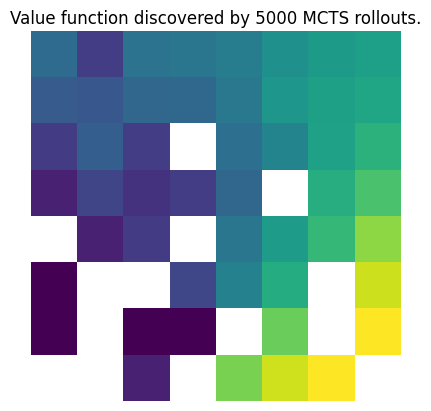

In [191]:
# MCTS estimated values in every state
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
model = FrozenLakeModel(env.P)
nS = flatdim(env.observation_space)
V = np.zeros(nS)
for i in trange(env.observation_space.n):
    _, values = MCTS(i, model, {"iters": 5000}).search()
    V[i] = np.mean([child.value for child in values.children.values()])

plt.imshow(np.log(V.reshape(int(np.sqrt(nS)), int(np.sqrt(nS)))))
plt.title("Value function discovered by 5000 MCTS rollouts.")
plt.axis("off")
plt.savefig("./frozen-lake/value-5000")

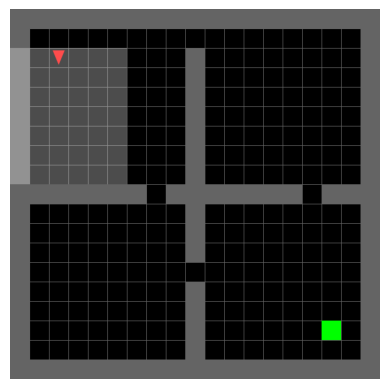

In [25]:
from minigrid.envs import FourRoomsEnv
import matplotlib.pyplot as plt
env = FourRoomsEnvPos(agent_pos=(2,2), goal_pos=(16,16))
obs, _ = env.reset(seed=42)

plt.imshow(env.get_frame())
plt.axis("off")
plt.savefig("./four-rooms/env")

In [36]:
class FourRoomsModel:
    def __init__(self, goal_pos=(16,16), seed=42):
        self.goal_pos = goal_pos
        self.seed = seed

    def step(self, agent_pos, action) -> tuple[_, float]:
        env = FourRoomsEnvPos(agent_pos=agent_pos, goal_pos=self.goal_pos)
        env.reset(seed=self.seed)
        return env.step(action)

    def actions(self, obs) -> list[int]:
        return list(range(env.action_space.n))

class FourRoomsEnvPos(FourRoomsEnv):
    def __init__(self, agent_pos=None, goal_pos=None, **kwargs):
        super().__init__(agent_pos=agent_pos, goal_pos=goal_pos, **kwargs)
        self.max_steps = 1000
    
    def step(self, action):
        _, r, terminated, truncated, _ = super().step(action)
        return self.agent_pos, r, terminated or truncated, _

    def reset(self, seed=None):
        obs, _ = super().reset(seed=seed)
        return self.agent_pos


action_map = {
    0: "left",
    1: "right",
    2: "forward",
    3: "pickup",
    4: "drop",
    5: "toggle",
    6: "done" 
}

defaultdict(<function <lambda> at 0x7faf707b9120>, {(2, 2): 1512, (2, 3): 1154, (2, 4): 352, (2, 5): 52, (2, 6): 5})


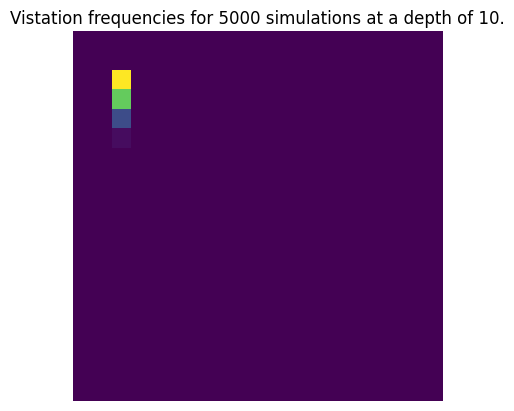

In [41]:
from collections import defaultdict

model = FourRoomsModel()
env = FourRoomsEnvPos(agent_pos=(2,2), goal_pos=(16,16))

obs = env.reset(seed=42)
action, root = MCTS(obs, model, {"iters": 5000, "sim_depth": 10}).search()


# Visualize visitation frequency
def unpack(root: Node, visit_freqs=defaultdict(lambda: 0)):
    if len(root.children.values()) == 0:
        visit_freqs[root.state] += root.visits
    
    for child in root.children.values():
        visit_freqs = unpack(child, visit_freqs)
    
    return visit_freqs


freqs = unpack(root)
print(freqs)
grid = np.zeros((19, 19))

for loc, visits in freqs.items():
    grid[loc[1], loc[0]] = visits

plt.imshow(grid)
plt.title("Vistation frequencies for 5000 simulations at a depth of 10.")
plt.axis("off")
plt.savefig("./four-rooms/visits")

# done = False
# ep_r = 0
# while not done:
#     action, values = MCTS(obs, model, {"iters": 50, "sim_depth": 200}).search()
#     print([(action_map[child.action], child.value) for child in values.children.values()])
#     print(f"Moving {action_map[action]}")
#     obs, r, done, _ = env.step(action)
#     # env.render()
    
#     print(obs, r, done)

#     ep_r += r

In [40]:
sum(list(freqs.values()))

3087